# Neural Trajectory Decoder

In [138]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.io import loadmat
import pandas as pd

## Data
Load and visualize data

### Load and Format

In [139]:
# Load data
data = loadmat("./data/JR_2015-12-04_truncated2.mat")

In [140]:
# Extract data field
R = data["R"][0]
R.shape

(506,)

`R` is $1\times 506$ array of structures with the following fields:

- `startDateNum`
- `startDateStr`
- `timeTargetOn`
- `timeTargetAcquire`
- `timeTargetHeld`
- `timeTrialEnd`
- `subject`
- `counter`
- `state`
- `cursorPos`
- `spikeRaster`
- `spikeRaster2`
- `isSuccessful`
- `trialNum`
- `timeFirstTargetAcquire`
- `timeLastTargetAcquire`
- `trialLength`
- `target`

We'll convert this to a dataframe for a more Pythonic representation. Each field will become a column with each row corresponding to an individual entry in `R`.

In [141]:
def clean_matlab_row(record):
    cleaned_row = {
        # Convert MATLAB datenum (days since 0000-01-00) to simple float
        'startDateNum': record['startDateNum'].item() if record['startDateNum'].size == 1 else record['startDateNum'],
        
        # Extract string from string array, removing unnecessary nesting
        'startDateStr': record['startDateStr'].item() if record['startDateStr'].size == 1 else record['startDateStr'],
        
        # Convert single-element arrays to scalar values
        'timeTargetOn': record['timeTargetOn'].item(),  # array([[21]]) -> 21
        'timeTargetAcquire': record['timeTargetAcquire'][0],  # Alternative way to get first element
        'timeTargetHeld': record['timeTargetHeld'].item(),
        'timeTrialEnd': record['timeTrialEnd'].item(),
        
        # Extract string value from array
        'subject': record['subject'].item(),  # array([['MonkeyJ']]) -> 'MonkeyJ'
        
        # Keep arrays for multi-value fields
        'counter': record['counter'][0],  # Keep as array if multiple values needed
        'state': record['state'][0],
        
        # Preserve multi-dimensional arrays
        'cursorPos': record['cursorPos'],  # 3xN array of positions
        
        # Keep sparse matrices as is (for efficiency)
        'spikeRaster': record['spikeRaster'],  # 96xT sparse binary matrix
        'spikeRaster2': record['spikeRaster2'],
        
        # Convert boolean arrays to simple Python booleans
        'isSuccessful': record['isSuccessful'].item() == 1,  # array([[True]]) -> True
        
        # Convert numeric arrays to simple Python numbers
        'trialNum': record['trialNum'].item(),
        'timeFirstTargetAcquire': record['timeFirstTargetAcquire'].item(),
        'timeLastTargetAcquire': record['timeLastTargetAcquire'].item(),
        'trialLength': record['trialLength'].item(),
        
        # Keep target coordinates as array
        'target': [i.item() for i in record['target']],  # 3x1 array [x,y,z]
    }
    return cleaned_row

In [142]:
rows = []
for record in R:
    cleaned_row = clean_matlab_row(record)
    rows.append(cleaned_row)

In [143]:
df = pd.DataFrame(rows)

In [144]:
df.head()

,startDateNum,startDateStr,timeTargetOn,timeTargetAcquire,timeTargetHeld,timeTrialEnd,subject,counter,state,cursorPos,spikeRaster,spikeRaster2,isSuccessful,trialNum,timeFirstTargetAcquire,timeLastTargetAcquire,trialLength,target
0,736302.569023,2015-12-04 13:39:23,21,[362],862,882,JenkinsC,"[763564, 763565, 763566, 763567, 763568, 76356...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[[81.97, 81.97, 81.97, 81.97, 81.97, 81.97, 81...","(np.int32(67), np.int32(0))\t1.0\n (np.int3...","(np.int32(49), np.int32(0))\t1.0\n (np.int3...",True,420,362,362,862,"[0, 0, -70]"
1,736302.569033,2015-12-04 13:39:24,21,[478],978,998,JenkinsC,"[764465, 764466, 764467, 764468, 764469, 76447...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[[1.73, 1.73, 1.73, 1.73, 1.73, 1.73, 1.73, 1....","(np.int32(39), np.int32(0))\t1.0\n (np.int3...","(np.int32(19), np.int32(0))\t1.0\n (np.int3...",True,421,478,478,978,"[0, -120, -70]"
2,736302.569045,2015-12-04 13:39:25,21,[411],911,931,JenkinsC,"[765482, 765483, 765484, 765485, 765486, 76548...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[[3.37, 3.37, 3.37, 3.37, 3.37, 3.37, 3.37, 3....","(np.int32(19), np.int32(0))\t1.0\n (np.int3...","(np.int32(84), np.int32(0))\t1.0\n (np.int3...",True,422,411,411,911,"[0, 0, -70]"
3,736302.569056,2015-12-04 13:39:26,21,[495],995,1015,JenkinsC,"[766432, 766433, 766434, 766435, 766436, 76643...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[[-2.35, -2.35, -2.35, -2.35, -2.35, -2.35, -2...","(np.int32(19), np.int32(0))\t1.0\n (np.int3...","(np.int32(18), np.int32(0))\t1.0\n (np.int3...",True,423,495,495,995,"[-84.85000000000001, -84.85000000000001, -70.0]"
4,736302.569068,2015-12-04 13:39:27,21,[361],861,881,JenkinsC,"[767466, 767467, 767468, 767469, 767470, 76747...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[[-85.83, -85.83, -85.83, -85.83, -85.83, -85....","(np.int32(60), np.int32(0))\t1.0\n (np.int3...","(np.int32(4), np.int32(0))\t1.0\n (np.int32...",True,424,361,361,861,"[0, 0, -70]"


### Trial Information

In [145]:
df.dtypes

startDateNum              float64
startDateStr               object
timeTargetOn                int64
timeTargetAcquire          object
timeTargetHeld              int64
timeTrialEnd                int64
subject                    object
counter                    object
state                      object
cursorPos                  object
spikeRaster                object
spikeRaster2               object
isSuccessful                 bool
trialNum                    int64
timeFirstTargetAcquire      int64
timeLastTargetAcquire       int64
trialLength                 int64
target                     object
dtype: object

Each element in the `R`-struct is a *trial*. `df[i]` represents the `i`th trial. A trial corresponds to a monkey being shown a target, then subsequently reaching for that target (note that there are no prepatory periods for the monkey to plan to reach, the monkey just reachest). In this dataset, the monkey contiguously makes $506$ reaches without pausing.

In [146]:
df.iloc[0]

startDateNum                                                  736302.569023
startDateStr                                            2015-12-04 13:39:23
timeTargetOn                                                             21
timeTargetAcquire                                                     [362]
timeTargetHeld                                                          862
timeTrialEnd                                                            882
subject                                                            JenkinsC
counter                   [763564, 763565, 763566, 763567, 763568, 76356...
state                     [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...
cursorPos                 [[81.97, 81.97, 81.97, 81.97, 81.97, 81.97, 81...
spikeRaster                 (np.int32(67), np.int32(0))\t1.0\n  (np.int3...
spikeRaster2                (np.int32(49), np.int32(0))\t1.0\n  (np.int3...
isSuccessful                                                           True
trialNum    

In [147]:
print(df["target"].iloc[[0, 1]])

0       [0, 0, -70]
1    [0, -120, -70]
Name: target, dtype: object


We see that in trial 1, the monkey's target was $(0,0,-70)$, and in trial 2 it was $(0, -120, -70)$. In this experiment we ignore the $z$-positions adn they'll all be $-70$, so we can ignore this information. All units are in millimeters.

In [148]:
df["target"] = df["target"].apply(lambda x: x[:2])
df[["target_x", "target_y"]] = df["target"].apply(pd.Series)  # Split target into two columns x,y

It turns out that in this experiment, the monkey was doing a "center-out-and-back" task, where the monkey acquires a center target, then reachest out to a radial target (on a circle with radius $12$ cm$), then back to the center target, then out to another radial target, etc. 

Let's plot all target locations.

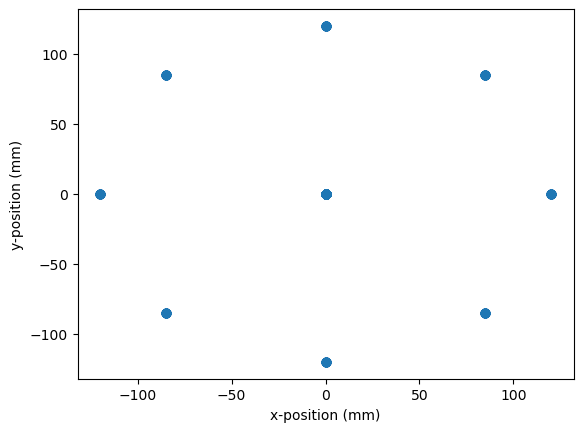

In [149]:
plt.figure()
plt.xlabel("x-position (mm)")
plt.ylabel("y-position (mm)")

# Plot all targets
plt.scatter(df["target_x"], df["target_y"], marker="o")

plt.show()

The `isSuccessful` field is a boolean that also tells us if a trial was succesful. We'd only want to train on trials that were successful, since if the monkey wasn't successful, he may not have been paying attention. We can claculate how many trials were successful, or filter to only maintain successful trials.

Note that in this specific dataset, all trials were successful.

In [150]:
df = df[df["isSuccessful"]]
df.shape

(506, 20)

### MS-Level Information
We also need to konw the kinematics and neural data at every single point in time. Our dataset also has this information.

`df.iloc[i]["cursorPos"]` is a $3\times T_i$ matrix that contains the monkeys hand positions over time on trial $i$, where $T_i$ is the length of trial $i$ in milliseconds. The first row is the $x$-position, and second is $y$-position. The third row is $z$-position (which, recall, we set to $-70$ mm by default). All units are in millimeters, and each column represents one millisecond.

In [153]:
df["cursorPos"] = df["cursorPos"].apply(lambda x: [x[:2]])

df.iloc[0]["cursorPos"]

[array([[81.97, 81.97, 81.97, ...,  1.73,  1.73,  1.73],
        [89.79, 89.79, 89.79, ...,  0.66,  0.66,  0.66]])]